In [1]:
import numpy as np
from scipy.integrate import simpson
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import trange

%matplotlib inline

C_LIGHT = 299792.458  # km/s
LN10    = np.log(10.0)

In [119]:
def rk_draw(n, rmin, rmax, k, rng):
    """Draw distances with prior p(r) ∝ r^k on [rmin, rmax]."""
    assert k > -1, "k must be > -1 for normalizable prior"
    u = rng.random(n)
    return (rmin**(k+1) + u * (rmax**(k+1) - rmin**(k+1)))**(1.0 / (k+1))


def simulate_catalog(n=1000, rmin=5.0, rmax=80.0, rmax_sel=None, czmax_sel=None,
                     H0_true=73.0, sigma_mu=0.4, sigma_vpec=300.0, seed=12345,
                     k=2, verbose=True):
    """
    Simulate a CF4-like catalog with TF μ and peculiar-velocity scatter.
    Distances are drawn from prior p(r) ∝ r^k on [rmin, rmax].
    """
    rng = np.random.default_rng(seed)

    if rmax_sel is not None:
        mu_max = 5.0 * np.log10(rmax_sel) + 25.0
        mu_max_sample = mu_max + 6 * sigma_mu
        rmax_sample = 10**((mu_max_sample - 25.0) / 5.0)

        r_true = []
        mu_obs = []

        batch_size = int(0.3 * n)

        i = 0
        nsampled = 0
        while nsampled < n:
            r_true_i = rk_draw(batch_size, rmin, rmax_sample, k, rng)
            mu_true_i = 5.0 * np.log10(r_true_i) + 25.0
            mu_obs_i = rng.normal(mu_true_i, sigma_mu, batch_size)
            mask = mu_obs_i < mu_max
            r_true.append(r_true_i[mask])
            mu_obs.append(mu_obs_i[mask])

            nsampled += mask.sum()
            i += 1

        r_true = np.concatenate(r_true)[:n]
        mu_obs = np.concatenate(mu_obs)[:n]
        if verbose:
            print(f"It took {i} iterations to get {len(r_true)} objects.")
        v_flow = H0_true * r_true
        v_obs = rng.normal(v_flow, sigma_vpec, n)  # observed Vcmb
    elif czmax_sel is not None:
        rmax_sample = czmax_sel / H0_true + 6 * sigma_vpec / H0_true
        r_true = []
        cz_obs = []

        batch_size = int(0.3 * n)

        i = 0
        nsampled = 0
        while nsampled < n:
            r_true_i = rk_draw(batch_size, rmin, rmax_sample, k, rng)
            v_flow_i = H0_true * r_true_i
            v_obs_i = rng.normal(v_flow_i, sigma_vpec, batch_size)
            mask = v_obs_i < czmax_sel
            r_true.append(r_true_i[mask])
            cz_obs.append(v_obs_i[mask])

            nsampled += mask.sum()
            i += 1
        
        r_true = np.concatenate(r_true)[:n]

        v_obs = np.concatenate(cz_obs)[:n]
        mu_obs = rng.normal(5.0 * np.log10(r_true) + 25.0, sigma_mu)

    else:
        r_true = rk_draw(n, rmin, rmax, k, rng)
        mu_true = 5.0 * np.log10(r_true) + 25.0
        mu_obs = rng.normal(mu_true, sigma_mu, n)

        v_flow = H0_true * r_true
        v_obs = rng.normal(v_flow, sigma_vpec, n)  # observed Vcmb

    return v_obs, mu_obs


In [66]:
def log_pdf_gauss(x, mu, sigma):
    """Log of Gaussian PDF."""
    return -0.5 * ((x - mu)/sigma)**2 - 0.5 * np.log(2 * np.pi * sigma**2)

def fit_H0(Vcmb, mu_obs, sigma_mu=0.4, sigma_vpec=None,
           h0_min=60.0, h0_max=85.0, h0_step=0.025, verbose=True, k=-1):
    """Grid posterior for H0."""
    H0_grid = np.arange(h0_min, h0_max + 0.5*h0_step, h0_step)
    if verbose:
        print(f"H0 grid: {H0_grid.size} points from {H0_grid[0]:.3f} to {H0_grid[-1]:.3f} km/s/Mpc")

    m = Vcmb > 0
    Vcmb, mu_obs = Vcmb[m], mu_obs[m]

    if sigma_vpec is not None:
        sigma_mu = np.sqrt(sigma_mu**2 + (5.0 / np.log(10.0) * sigma_vpec / Vcmb)**2)
    else:
        sigma_mu = np.ones_like(mu_obs) * sigma_mu

    # Shape `(n_H0, n_data)`
    lp = log_pdf_gauss(mu_obs[None, :], 5 * np.log10(Vcmb[None, :] / H0_grid[:, None]) + 25.0, sigma_mu[None, :])
    lp -= (k + 1) * np.log(H0_grid[:, None])

    # Shape `(n_H0, )`
    lp = np.sum(lp, axis=-1)

    # stabilize and normalize
    p = np.exp(lp - lp.max())
    norm = simpson(p, x=H0_grid)
    if np.isfinite(norm) and norm>0:
        p /= norm

    H0_mean = simpson(p * H0_grid, x=H0_grid)
    H0_std = np.sqrt(simpson(p * (H0_grid - H0_mean)**2, x=H0_grid))

    return H0_mean, H0_std


In [75]:
n = 2000
rmin = 5
rmax = 100
H0_true = 70.0
sigma_mu = 0.1
sigma_vpec = 300
# czmax_sel = H0_true * 100
czmax_sel = None
rmax_sel = 100


seed = 48

sigma_vpec_range = np.linspace(0, 500,  10)
nrepeat_per_sigma_v = 100

H0_mean = np.empty((len(sigma_vpec_range), nrepeat_per_sigma_v))
H0_std  = np.empty((len(sigma_vpec_range), nrepeat_per_sigma_v))

H0_mean_prop = np.empty((len(sigma_vpec_range), nrepeat_per_sigma_v))
H0_std_prop  = np.empty((len(sigma_vpec_range), nrepeat_per_sigma_v))


for i, sigma_vpec in enumerate(sigma_vpec_range):
    catalogue_kwargs = dict(
        n=n, rmin=rmin, rmax=rmax, H0_true=H0_true,
        sigma_mu=sigma_mu, sigma_vpec=sigma_vpec, czmax_sel=czmax_sel, rmax_sel=rmax_sel, verbose=False)
    fit_kwargs = dict(sigma_mu=sigma_mu,
                      h0_min=50, h0_max=100.0, h0_step=0.01)
    print(f"\nSimulating catalogs with σ_vpec = {sigma_vpec:.1f} km/s")

    for j in range(nrepeat_per_sigma_v):
        Vcmb, mu_obs = simulate_catalog(**catalogue_kwargs, seed=seed + j)

        H0_mean[i, j], H0_std[i, j] = fit_H0(Vcmb, mu_obs, **fit_kwargs, sigma_vpec=None, verbose=False, )
        H0_mean_prop[i, j], H0_std_prop[i, j] = fit_H0(Vcmb, mu_obs, **fit_kwargs, sigma_vpec=sigma_vpec,verbose=False, )

    # H0_mean[i], H0_std[i] = fit_H0(Vcmb, mu_obs, **fit_kwargs, verbose=False, )


Simulating catalogs with σ_vpec = 0.0 km/s

Simulating catalogs with σ_vpec = 55.6 km/s

Simulating catalogs with σ_vpec = 111.1 km/s

Simulating catalogs with σ_vpec = 166.7 km/s

Simulating catalogs with σ_vpec = 222.2 km/s

Simulating catalogs with σ_vpec = 277.8 km/s

Simulating catalogs with σ_vpec = 333.3 km/s

Simulating catalogs with σ_vpec = 388.9 km/s

Simulating catalogs with σ_vpec = 444.4 km/s

Simulating catalogs with σ_vpec = 500.0 km/s


In [76]:
dH0 = H0_mean - H0_true
dH0_prop = H0_mean_prop - H0_true

np.savetxt(
    "chi2_H0_magnitude_limited.txt",
    np.vstack([sigma_vpec_range, dH0.mean(axis=1), dH0.std(axis=1), dH0_prop.mean(axis=1), dH0_prop.std(axis=1)]).T, header="sigma_vpec dH0_mean dH0_std dH0_prop_mean dH0_prop_std")

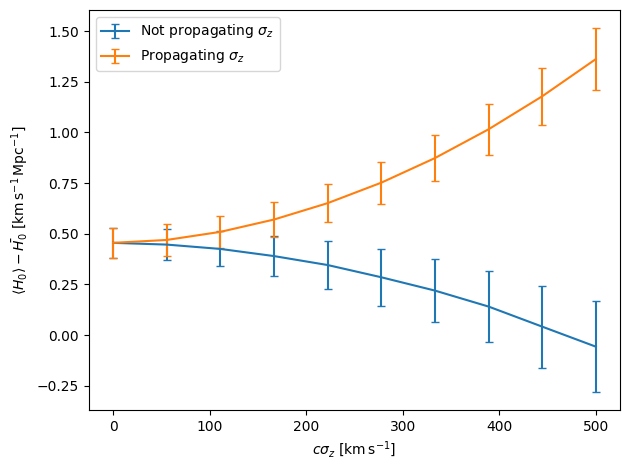

In [ ]:

plt.figure()
dH0 = H0_mean - H0_true
y = np.mean(dH0, axis=1)
yerr = np.std(dH0, axis=1) 
plt.errorbar(sigma_vpec_range, y, yerr=yerr, capsize=3, label=r"Not propagating $\sigma_z$")

dH0_prop = H0_mean_prop - H0_true
y_prop = np.mean(dH0_prop, axis=1)
yerr_prop = np.std(dH0_prop, axis=1)
plt.errorbar(sigma_vpec_range, y_prop, yerr=yerr_prop, capsize=3, label=r"Propagating $\sigma_z$")

plt.ylabel(r"$\langle H_0 \rangle - \bar{H_0} ~ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$")
plt.xlabel(r"$c\sigma_{z} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
plt.legend()
plt.tight_layout()

# plt.savefig("/Users/rstiskalek/Downloads/bias_test_magnitude_limited.png", dpi=450)

plt.show()

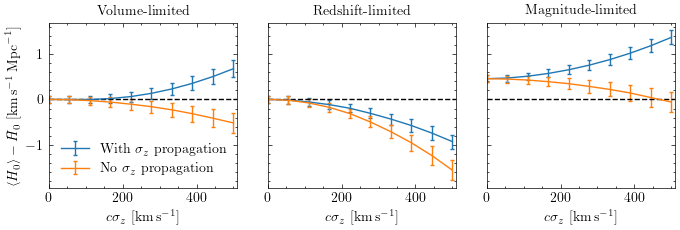

In [118]:
import scienceplots

# Load data
Xv = np.loadtxt("chi2_H0_volume_limited.txt")
Xz = np.loadtxt("chi2_H0_redshift_limited.txt")
Xm = np.loadtxt("chi2_H0_magnitude_limited.txt")

# Create figure with 3 side-by-side panels
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 3, figsize=(7.0, 2.5), sharey=True)

    labels = ["Volume-limited", "Redshift-limited", "Magnitude-limited"]
    datasets = [Xv, Xz, Xm]

    for ax, X, lab in zip(axes, datasets, labels):
        ax.errorbar(X[:, 0], X[:, 3], yerr=X[:, 4], capsize=1.5, label=r"With $\sigma_z$ propagation", c="tab:blue")
        ax.errorbar(X[:, 0], X[:, 1], yerr=X[:, 2], capsize=1.5, label=r"No $\sigma_z$ propagation", c="tab:orange")
        ax.set_xlabel(r"$c\sigma_{z} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
        ax.set_title(lab, fontsize=10)
        ax.axhline(0, ls="--", c="k")
        ax.set_xlim(0, 510)

    axes[0].set_ylabel(r"$\langle H_0 \rangle - \bar{H}_0 ~ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$")
    axes[0].legend()
    plt.tight_layout(w_pad=0.2)
    plt.savefig("/Users/rstiskalek/Downloads/bias_test_chi2.pdf", dpi=450)
    plt.show()

In [120]:
import candel